##### Arquitectura Naive v0

- This notebook extends the naive RAG framework to handle multiple queries simultaneously.

- This notebook involves more complex interaction with the vector storage and a parallel or multi-threaded processing approach to handle multiple data streams
- ![alt text](../sagemaker_documentation/images/Naive_arch.png)

In [1]:
import sys
sys.path.append('C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/src')

import os
from dotenv import load_dotenv

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from operator import itemgetter
from config import CHUNK_SIZE_SPLIT, CHUNK_OVERLAP, SEARCH_ITEMS, LLM_MODEL
from matplotlib.colors import LinearSegmentedColormap
from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader, DirectoryLoader

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
DIR_PATH = "C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/sagemaker_documentation/sagemaker_documentation"

In [4]:
# Load documents
loader = DirectoryLoader(
    DIR_PATH, glob="*.md", loader_cls=UnstructuredMarkdownLoader
)
docs = loader.load()

In [5]:
# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE_SPLIT, 
    chunk_overlap=CHUNK_OVERLAP
)
splits = text_splitter.split_documents(docs)

# RAGAS expects a file_name dict as key
for document in splits:
    document.metadata['file_name'] = document.metadata['source']

In [6]:
# Embed and create retriever
vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever(search_kwargs={"k": SEARCH_ITEMS})

In [7]:
# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [8]:
generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [9]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    fused_scores = {}

    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)

            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

question = "Whe sage maker create a model what happen?"
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


2

In [10]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

llm = ChatOpenAI(model_name=LLM_MODEL, temperature=0)

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'When SageMaker creates a model, the user can either choose an existing IAM role with the required permissions to call other services on their behalf, or they can choose to create a new role. If they choose to create a new role, SageMaker will create a role with the AmazonSageMakerFullAccess managed policy attached.'

##### RAGAS TEST

In [11]:
# Ragas wants ['question', 'answer', 'contexts', 'ground_truths'] as
'''
{
    "question": [], <-- question from faq doc
    "answer": [], <-- answer from generated result
    "contexts": [], <-- context
    "ground_truths": [] <-- actual answer
}
'''

from datasets import Dataset

questions = [
    "What is SageMaker?", 
    "What are all AWS regions where SageMaker is available?",
    "How to check if an endpoint is KMS encrypted?",
    "What are SageMaker Geospatial capabilities?",
    "What is Amazon SageMaker?",
    "How does SageMaker handle model training scalability?",
    "Can SageMaker integrate with other AWS services?",
    "What are SageMaker notebooks?",
    "How does SageMaker ensure model security?",
    "What is SageMaker Autopilot?",
    "How does model monitoring work in SageMaker?",
    "What types of machine learning models can SageMaker deploy?",
    "How does SageMaker optimize model performance?",
    "Can SageMaker process real-time data for predictions?"
]

ground_truths = [
    ["SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud."],
    ["AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East."],
    ["To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI."],
    ["SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis."],
    ["Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly."],
    ["SageMaker automatically scales the training jobs by adjusting the number of instances based on the workload, ensuring efficient use of resources."],
    ["Yes, SageMaker integrates seamlessly with AWS services like S3 for data storage, IAM for security, and Lambda for serverless computing, enhancing its capabilities."],
    ["SageMaker notebooks are Jupyter notebooks hosted on SageMaker, enabling data scientists to prepare and process data, visualize results, and experiment with models directly."],
    ["SageMaker uses AWS IAM to control access, encrypts data at rest using KMS, and data in transit using SSL to ensure secure model training and deployment."],
    ["SageMaker Autopilot is an automated machine learning (AutoML) service that automatically creates, trains, and tunes the best machine learning models based on the data provided."],
    ["SageMaker Model Monitor continuously tracks the models performance in production, detecting deviations in model quality to provide alerts and insights."],
    ["SageMaker supports all common machine learning models, including linear regression, classification, and deep learning models like CNNs and RNNs."],
    ["SageMaker optimizes models by using hyperparameter tuning to automatically find the best version of a model based on the defined criteria and metrics."],
    ["Yes, SageMaker offers real-time prediction capabilities through endpoints that are scalable and can process thousands of requests per second."]
]

answers = []
contexts = []

# Inference
for query in questions:
    answers.append(final_rag_chain.invoke({"question":query}))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    answer_similarity,
    answer_correctness,
    context_precision,
    context_recall,
    faithfulness,
    context_entity_recall
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        context_precision,
        context_recall,
        faithfulness,
        context_entity_recall
    ],
)

result

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]


{'answer_relevancy': 0.8356, 'answer_similarity': 0.9187, 'answer_correctness': 0.5898, 'context_precision': 0.7143, 'context_recall': 0.8393, 'faithfulness': 0.7821, 'context_entity_recall': 0.2269}

In [13]:
pd.set_option("display.max_colwidth", None)

df = result.to_pandas()

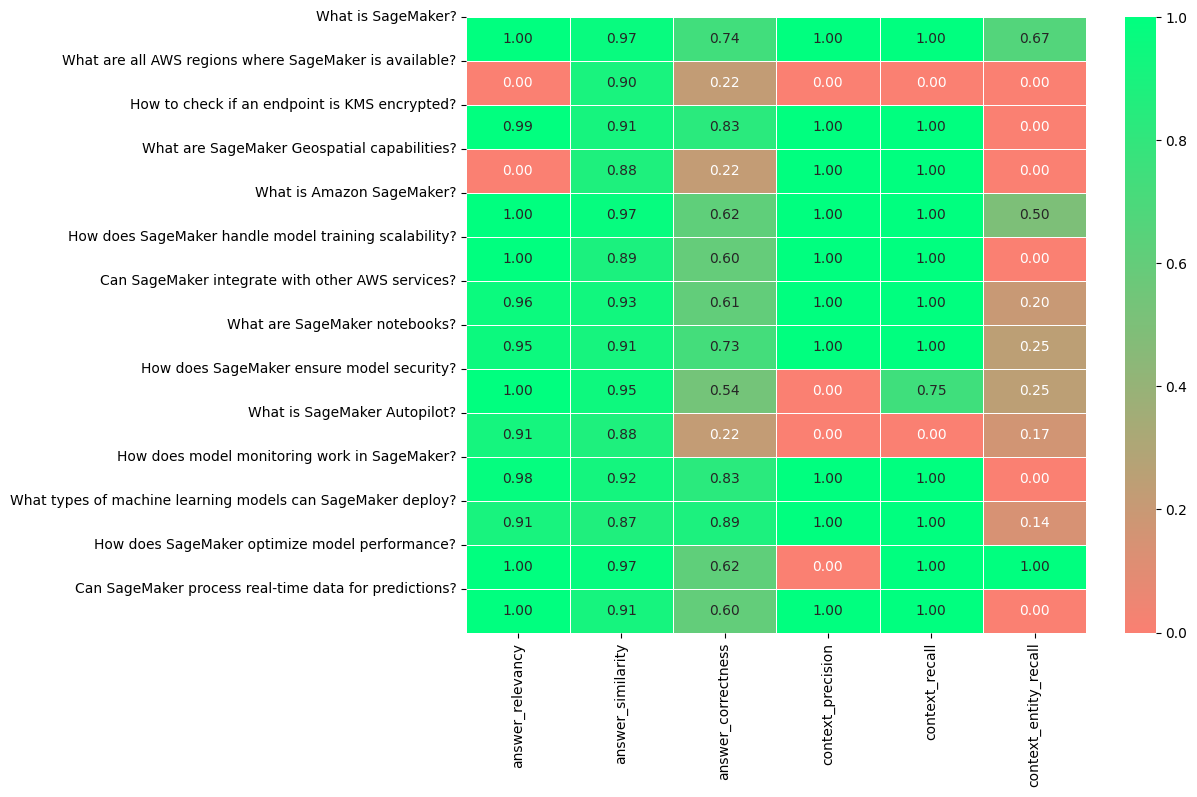

In [14]:
df = result.to_pandas()

heatmap_data = df[[
    "answer_relevancy",
    "answer_similarity",
    "answer_correctness",
    "context_precision",
    "context_recall",
    "context_entity_recall"
]]

cmap = LinearSegmentedColormap.from_list('green_red', ['salmon', 'springgreen'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()